# CIFAR Table 1

TJ Kim

1.17.22

#### Summary:
- Make a table for Benign transferability and inter-boundary distance for following models
- Local benign, fedavg benign, fedEM benign

In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

### Load Regular

In [3]:
# Load blackbox model
setting = 'FedEM'

if setting == 'FedEM':
    n = 3
else:
    n = 1


# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar10"
args_.method = setting
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= n
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/dummy/'
args_.validation = False

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=40)

==> Clients initialization..
===> Building data iterators..


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 209.08it/s]


===> Initializing clients..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.54it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.292 | Train Acc: 12.195% |Test Loss: 2.292 | Test Acc: 12.291% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [35]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

dataloader = Custom_Dataloader(data_x, data_y)

Load local model.

In [78]:
num_models = 40

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


args_.save_path = 'weights/cifar/21_12_30_feddef_n40_linf0_5_G0_0/'
# args_.save_path = 'weights/final/cifar/fig3/fedem_defend/'
aggregator.load_state(args_.save_path)

# This is where the models are stored -- one for each mixture --> learner.model for nn
hypotheses = aggregator.global_learners_ensemble.learners

# obtain the state dict for each of the weights 
weights_h = []

for h in hypotheses:
    weights_h += [h.model.state_dict()]

weights = np.load("weights/cifar/21_12_30_feddef_n40_linf0_5_G0_0/train_client_weights.npy")
# weights = np.load("weights/final/cifar/fig3/fedem_defend/train_client_weights.npy")

# Set model weights
model_weights = []

for i in range(num_models):
    model_weights += [weights[i]]


# Generate the weights to test on as linear combinations of the model_weights
models_test = []

for (w0,w1,w2) in model_weights:
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    new_model.eval()
    new_weight_dict = copy.deepcopy(weights_h[0])
    for key in weights_h[0]:
        new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
    new_model.load_state_dict(new_weight_dict)
    models_test += [new_model]
    
models_fake = []
new_model_weights = [(1,0,0), (0,1,0),(0,0,1), (0.5,0.5,0), (0.5,0,0.5),(0,0.5,0.5),(0.33,0.33,0.34)]

for (w0,w1,w2) in new_model_weights:
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    new_model.eval()
    new_weight_dict = copy.deepcopy(weights_h[0])
    for key in weights_h[0]:
        new_weight_dict[key] = w0*weights_h[0][key] + w1*weights_h[1][key] + w2*weights_h[2][key]
    new_model.load_state_dict(new_weight_dict)
    models_fake += [new_model]
    

Set Up Transfer Attack Scenario

In [79]:
logs_adv = []

for i in range(len(new_model_weights)):
    adv_dict = {}
    adv_dict['orig_acc_transfers'] = None
    adv_dict['orig_similarities'] = None
    adv_dict['adv_acc_transfers'] = None
    adv_dict['adv_similarities_target'] = None
    adv_dict['adv_similarities_untarget'] = None
    adv_dict['adv_target'] = None
    adv_dict['adv_miss'] = None
    adv_dict['metric_alignment'] = None
    adv_dict['ib_distance_legit'] = None
    adv_dict['ib_distance_adv'] = None

    logs_adv += [adv_dict]


In [80]:
all_models = models_test + models_fake

In [81]:
# Run Measurements for both targetted and untargeted analysis
victim_idxs = range(num_models)
custom_batch_size = 300


for i in range(len(new_model_weights)):
    adv_idx = num_models + i
    print("\t Adv idx:", adv_idx)
        
    batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
    
    t1 = Transferer(models_list=all_models, dataloader=dataloader)
    t1.generate_victims(victim_idxs)
    
    # Perform Attacks
    t1.atk_params = PGD_Params()
    t1.atk_params.set_params(batch_size=batch_size, iteration = 20,
                   target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
    
    t1.generate_advNN(adv_idx)
    t1.generate_xadv(atk_type = "pgd")
    t1.send_to_victims(victim_idxs)

    # Log Performance
    logs_adv[i]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
    logs_adv[i]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
    logs_adv[i]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
    logs_adv[i]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
    logs_adv[i]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

    # Miss attack
    t1.atk_params.set_params(batch_size=batch_size, iteration = 30,
                   target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                   step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    t1.generate_xadv(atk_type = "pgd")
    t1.send_to_victims(victim_idxs)
    logs_adv[i]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
    logs_adv[i]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)

	 Adv idx: 40
	 Adv idx: 41
	 Adv idx: 42
	 Adv idx: 43
	 Adv idx: 44
	 Adv idx: 45
	 Adv idx: 46


Print Relevant Information

In [82]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']

orig_acc = np.zeros([len(new_model_weights), num_models]) 
orig_sim = np.zeros([len(new_model_weights), num_models]) 
adv_acc = np.zeros([len(new_model_weights), num_models]) 
adv_sim_target = np.zeros([len(new_model_weights), num_models]) 
adv_sim_untarget = np.zeros([len(new_model_weights), num_models]) 
adv_target = np.zeros([len(new_model_weights), num_models])
adv_miss = np.zeros([len(new_model_weights), num_models]) 

for adv_idx in range(len(new_model_weights)):
    for victim in range(num_models):
        orig_acc[adv_idx,victim] = logs_adv[adv_idx][metrics[0]][victim_idxs[victim]].data.tolist()
        orig_sim[adv_idx,victim] = logs_adv[adv_idx][metrics[1]][victim_idxs[victim]].data.tolist()
        adv_acc[adv_idx,victim] = logs_adv[adv_idx][metrics[2]][victim_idxs[victim]].data.tolist()
        adv_sim_target[adv_idx,victim] = logs_adv[adv_idx][metrics[3]][victim_idxs[victim]].data.tolist()
        adv_sim_untarget[adv_idx,victim] = logs_adv[adv_idx][metrics[4]][victim_idxs[victim]].data.tolist()
        adv_target[adv_idx,victim] = logs_adv[adv_idx][metrics[5]][victim_idxs[victim]].data.tolist()
        adv_miss[adv_idx,victim] = logs_adv[adv_idx][metrics[6]][victim_idxs[victim]].data.tolist()

In [83]:
aa = np.mean(adv_miss, axis=1)

for i in range(len(new_model_weights)):
    print("prop:", new_model_weights[i])
    print("advmiss:",aa[i])

prop: (1, 0, 0)
advmiss: 0.19591667084023356
prop: (0, 1, 0)
advmiss: 0.22908334033563732
prop: (0, 0, 1)
advmiss: 0.14716667025350033
prop: (0.5, 0.5, 0)
advmiss: 0.09250000147148967
prop: (0.5, 0, 0.5)
advmiss: 0.0645833347691223
prop: (0, 0.5, 0.5)
advmiss: 0.10891666943207383
prop: (0.33, 0.33, 0.34)
advmiss: 0.05158333471044898


In [3]:
pfeddef_ones = np.mean([0.5425, 0.5972, 0.4895])
pfeddef_twos = np.mean([0.5512, 0.5199, 0.5640])
pffedef_three = 0.54991

fedem_ones = np.mean([0.1959,0.2290,0.1471])
fedem_twos = np.mean([0.0925, 0.0645, 0.1089])
fedem_three = 0.05158

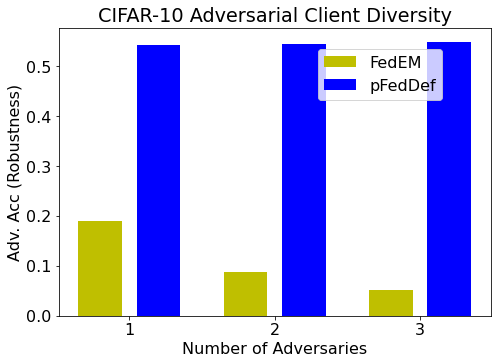

In [13]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

names = [1,2,3]

data = [[fedem_ones, fedem_twos, fedem_three],
[pfeddef_ones, pfeddef_twos, pffedef_three]]
X = np.arange(3) + 1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.2, data[0], color = 'y', width = 0.3, label = 'FedEM')
ax.bar(X + 0.2, data[1], color = 'b', width = 0.3, label = 'pFedDef')

plt.xticks(X)

plt.xlabel('Number of Adversaries')
plt.ylabel('Adv. Acc (Robustness)')
plt.title("CIFAR-10 Adversarial Client Diversity")
plt.legend(frameon=True, loc= (0.6,0.75))


plt.show()


In [109]:
X

array([0, 1, 2])